In [18]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim

In [64]:
def resample_and_interpolate(group):
    return group.reset_index(level=[1, 2]).resample('30T').asfreq().interpolate()

In [65]:
weather_df = pd.read_csv('D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/weather_data/DWD_ICON-EU.csv')
solar_total = pd.read_csv('D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/basic_files/solar_total_production.csv')
solar_total.generation_mw = solar_total.generation_mw * 0.5
weather_df.sort_values(by='ref_datetime', inplace=True)
weather_df = weather_df.groupby(["valid_datetime","latitude","longitude"]).last().reset_index()
weather_df.reset_index(inplace=True)

In [66]:
weather_df.valid_datetime = pd.to_datetime(weather_df.valid_datetime)
weather_df = weather_df.set_index(["valid_datetime","latitude","longitude"])
df_resampled = weather_df.groupby(['latitude', 'longitude'], group_keys=False).apply(resample_and_interpolate)
df_resampled = df_resampled.reset_index()

C:\Users\paulh\AppData\Local\Temp\ipykernel_29320\2834871732.py:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

C:\Users\paulh\AppData\Local\Temp\ipykernel_29320\2834871732.py:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

C:\Users\paulh\AppData\Local\Temp\ipykernel_29320\2834871732.py:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

C:\Users\paulh\AppData\Local\Temp\ipykernel_29320\2834871732.py:2: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

C:\Users\paulh\AppData\Local\Temp\ipykernel_

In [67]:
solar_total.timestamp_utc = pd.to_datetime(solar_total.timestamp_utc)
df_resampled.drop(columns=['index','ref_datetime'], inplace=True)
df_resampled_merged = pd.merge(df_resampled, solar_total, how='left', left_on='valid_datetime', right_on='timestamp_utc')
df_resampled_merged_solar = df_resampled_merged.loc[~(df_resampled_merged.latitude == 53.935) & ~(df_resampled_merged.longitude == 1.8645)]

In [68]:
df_resampled_merged_solar1 = df_resampled_merged_solar.groupby("valid_datetime").mean().reset_index()

In [69]:
distinct_lat_lon_pairs = df_resampled_merged_solar[['latitude', 'longitude']].drop_duplicates()

In [70]:
def set_up_solar_features(df):
    df["hour"] = df.valid_datetime.dt.hour
    df["day_of_year"] = df.valid_datetime.dt.dayofyear
    df["cos_day_of_year"] = np.cos(2 * np.pi * df.day_of_year / 365)
    df["cos_hour"] = np.cos(2 * np.pi * df.hour / 24)
    df["Mean_SolarDownwardRadiation"] = df.SolarDownwardRadiation
    df["Mean_Temperature"] = df.Temperature
    df["Std_Temperature"] = df_resampled_merged_solar.groupby("valid_datetime").std().reset_index().Temperature
    df["SolarDownwardRadiation_RW_Mean_30min"] = df.Mean_SolarDownwardRadiation.rolling(window=1, min_periods=1).mean()
    df["SolarDownwardRadiation_RW_Mean_1hour"] = df.Mean_SolarDownwardRadiation.rolling(window=2, min_periods=1).mean()
    df["SolarDownwardRadiation_dwd_Mean_Lag_30min"] = df.Mean_SolarDownwardRadiation.shift(1)
    df["SolarDownwardRadiation_dwd_Mean_Lag_1h"] = df.Mean_SolarDownwardRadiation.shift(2)
    df["SolarDownwardRadiation_dwd_Mean_Lag_24h"] = df.Mean_SolarDownwardRadiation.shift(48)
    for i in range(len(distinct_lat_lon_pairs)):
        lat = distinct_lat_lon_pairs.latitude.iloc[i]
        lon = distinct_lat_lon_pairs.longitude.iloc[i]
        mask = (df_resampled_merged_solar.latitude == lat) & (df_resampled_merged_solar.longitude == lon)
        df[f"Temperature_{i}"] = pd.Series(df_resampled_merged_solar.Temperature[mask].values)[:len(df)]  # Fill gaps with NaN
        df[f"SolarDownwardRadiation_{i}"] = pd.Series(df_resampled_merged_solar.SolarDownwardRadiation[mask].values)[:len(df)]  # Fill gaps with NaN
    return df
df_resampled_merged_solar2 = set_up_solar_features(df_resampled_merged_solar1)

In [71]:
def pv_temperature_efficiency(irradiance, ambient_temp, NOCT=45, wind_speed=1, eta_0=0.18, beta=0.004):
    # Calculate cell temperature using the simplified NOCT model
    Tc = ambient_temp + (NOCT - 20) * (irradiance / 800)
    
    # Calculate the efficiency loss due to increased cell temperature
    efficiency = eta_0 * (1 - beta * (Tc - 25))
    
    return Tc, efficiency

In [72]:
for i in range(20):
    temp_col = f'Temperature_{i}'
    irradiance_col = f'SolarDownwardRadiation_{i}'
    panel_temp_col = f'Panel_Temperature_Point{i}'
    panel_eff_col = f'Panel_Efficiency_Point{i}'
    df_resampled_merged_solar2[panel_temp_col], df_resampled_merged_solar2[panel_eff_col] = pv_temperature_efficiency(df_resampled_merged_solar2[irradiance_col], df_resampled_merged_solar2[temp_col])

In [73]:
df_resampled_merged_solar2["Panel_Temperature_dwd_mean"] = df_resampled_merged_solar2.filter(regex= r"Panel_Temperature.*").mean(axis= 1)
df_resampled_merged_solar2["Panel_Efficiency_dwd_mean"] = df_resampled_merged_solar2.filter(regex= r"Panel_Efficiency.*").mean(axis= 1)
df_resampled_merged_solar2["Panel_Temperature_dwd_std"] = df_resampled_merged_solar2.filter(regex= r"Panel_Temperature.*").std(axis= 1)
df_resampled_merged_solar2["Panel_Efficiency_dwd_std"] = df_resampled_merged_solar2.filter(regex= r"Panel_Efficiency.*").std(axis= 1)

In [74]:
df_resampled_merged_solar2["solar_mw_lag_48h"] = df_resampled_merged_solar2.generation_mw.shift(periods= 96)
df_resampled_merged_solar2["capacity_mwp_lag_48h"] = df_resampled_merged_solar2.capacity_mwp.shift(periods= 96)
df_resampled_merged_solar2["Target_Capacity_MWP%"] = df_resampled_merged_solar2.generation_mw / df_resampled_merged_solar2.capacity_mwp
df_resampled_merged_solar2["capacity_mwp_lag_48h"] = df_resampled_merged_solar2.capacity_mwp.shift(periods= 96)
df_resampled_merged_solar2["Target_Capacity_MWP%_lag_48h"] = df_resampled_merged_solar2["Target_Capacity_MWP%"].shift(periods= 96)
df_resampled_merged_solar2.generation_mw = df_resampled_merged_solar2.generation_mw / df_resampled_merged_solar2.capacity_mwp

C:\Users\paulh\AppData\Local\Temp\ipykernel_29320\3718892184.py:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [82]:
df_resampled_merged_solar3 = df_resampled_merged_solar2[[ 
    "Mean_SolarDownwardRadiation",
    "SolarDownwardRadiation_RW_Mean_30min",
    "SolarDownwardRadiation_RW_Mean_1hour",
    "SolarDownwardRadiation_dwd_Mean_Lag_30min",
    "SolarDownwardRadiation_dwd_Mean_Lag_1h",
    "SolarDownwardRadiation_dwd_Mean_Lag_24h",
    "Panel_Efficiency_dwd_mean",
    "Panel_Efficiency_dwd_std",
    "Panel_Temperature_dwd_mean",
    "Panel_Temperature_dwd_std",
    "Std_Temperature",
    "Mean_Temperature",
    "cos_hour",
    "cos_day_of_year","solar_mw_lag_48h","capacity_mwp_lag_48h","Target_Capacity_MWP%_lag_48h",
    "generation_mw"]]
df_resampled_merged_solar3.dropna(inplace=True)

C:\Users\paulh\AppData\Local\Temp\ipykernel_29320\4222733903.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [76]:
df_resampled_merged_solar3.capacity_mwp_lag_48h.mean()

2779.046078417549

solar

In [39]:
df_resampled_merged_solar3

,Mean_SolarDownwardRadiation,SolarDownwardRadiation_RW_Mean_30min,SolarDownwardRadiation_RW_Mean_1hour,SolarDownwardRadiation_dwd_Mean_Lag_30min,SolarDownwardRadiation_dwd_Mean_Lag_1h,SolarDownwardRadiation_dwd_Mean_Lag_24h,Panel_Efficiency_dwd_mean,Panel_Efficiency_dwd_std,Panel_Temperature_dwd_mean,Panel_Temperature_dwd_std,Std_Temperature,Mean_Temperature,cos_hour,cos_day_of_year,solar_mw_lag_48h,capacity_mwp_lag_48h,Target_Capacity_MWP%_lag_48h,Target_Capacity_MWP%,generation_mw
96,0.0,0.0,0.0,0.0,0.0,0.0,0.188081,0.000357,13.77600,0.496404,0.337606,13.58750,1.000000,0.158559,0.0,2779.542388,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.188098,0.000327,13.75300,0.454666,0.349814,13.48025,1.000000,0.158559,0.0,2779.542384,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.188098,0.000327,13.75300,0.454666,0.370293,13.37300,0.965926,0.158559,0.0,2779.542383,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.188134,0.000287,13.70275,0.399291,0.364783,13.32325,0.965926,0.158559,0.0,2779.542370,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.188134,0.000287,13.70275,0.399291,0.362641,13.27350,0.866025,0.158559,0.0,2779.542348,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,0.0,0.0,0.0,0.0,0.0,0.0,0.190850,0.000320,9.93050,0.444865,0.931157,11.66000,0.707107,0.421101,0.0,2778.506146,0.0,0.0,0.0
871,0.0,0.0,0.0,0.0,0.0,0.0,0.191070,0.000339,9.62550,0.470831,0.883660,11.78950,0.707107,0.421101,0.0,2778.506125,0.0,0.0,0.0
872,0.0,0.0,0.0,0.0,0.0,0.0,0.191289,0.000367,9.32050,0.510112,0.839103,11.91900,0.500000,0.421101,0.0,2778.506113,0.0,0.0,0.0
873,0.0,0.0,0.0,0.0,0.0,0.0,0.191368,0.000374,9.21175,0.519472,0.796528,12.02450,0.500000,0.421101,0.0,2778.506112,0.0,0.0,0.0


In [83]:
#load scaler and model
import pickle
from sklearn.preprocessing import StandardScaler

scaler = pickle.load(open('D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/paul_analyse/scaler.pkl', 'rb'))
X = df_resampled_merged_solar3.drop(columns=["generation_mw"])
X_scaled = scaler.transform(X)
Y = df_resampled_merged_solar3.generation_mw
Y = Y

c:\Users\paulh\anaconda3\envs\HEFTcom24\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



In [84]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        # Layer sizes from the best trial
        layer_sizes = [256, 448, 192, 96]
        dropout_rates = [0.12338360578207397, 0.2192742565593194, 0.15708417985889997, 0.253419888887539]

        # Define the layers
        self.fc1 = nn.Linear(input_dim, layer_sizes[0])
        self.fc2 = nn.Linear(layer_sizes[0], layer_sizes[1])
        self.fc3 = nn.Linear(layer_sizes[1], layer_sizes[2])
        self.fc4 = nn.Linear(layer_sizes[2], layer_sizes[3])
        self.fc5 = nn.Linear(layer_sizes[3], 9)  # Output layer

        # Dropouts
        self.dropout1 = nn.Dropout(dropout_rates[0])
        self.dropout2 = nn.Dropout(dropout_rates[1])
        self.dropout3 = nn.Dropout(dropout_rates[2])
        self.dropout4 = nn.Dropout(dropout_rates[3])

        # Activation function (Swish)
        self.swish = nn.SiLU()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # First layer with ReLU
        x = self.dropout1(x)         # First dropout
        x = self.swish(self.fc2(x))  # Second layer with Swish
        x = self.dropout2(x)         # Second dropout
        x = self.swish(self.fc3(x))  # Third layer with Swish
        x = self.dropout3(x)         # Third dropout
        x = self.swish(self.fc4(x))  # Fourth layer with Swish
        x = self.dropout4(x)         # Fourth dropout
        x = self.fc5(x)              # Output layer (no activation for raw outputs)
        return x

In [70]:
# import torch
# import torch.nn as nn

# # Define the MLP model
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         # Single hidden layer with 416 neurons as suggested by Optuna
#         self.fc1 = nn.Linear(input_dim, 416)
#         self.fc2 = nn.Linear(416, 9)  # Output layer with 9 neurons for quantiles
        
#         # Dropout with rate close to Optuna's suggestion
#         self.dropout = nn.Dropout(0.13)
#         self.swish = nn.SiLU()
    
#     def forward(self, x):
#         x = self.swish(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

In [85]:
# Load the model from the file
model = MLP(X_scaled.shape[1])
model.load_state_dict(torch.load('D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/paul_analyse/best_model.pth'))

C:\Users\paulh\AppData\Local\Temp\ipykernel_29320\3823507941.py:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

In [97]:
#make predictions
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).numpy()

predictions

array([[-1.33359252e-04, -1.74794710e-04, -2.37864569e-05, ...,
         5.56664309e-05,  1.13869472e-04,  4.79294722e-05],
       [-1.33760623e-04, -1.75524707e-04, -2.45444880e-05, ...,
         5.48194512e-05,  1.13090464e-04,  4.73088330e-05],
       [-1.33324007e-04, -1.75406240e-04, -2.44109506e-05, ...,
         5.52659149e-05,  1.13441129e-04,  4.76643327e-05],
       ...,
       [-1.33371912e-04, -1.79149065e-04, -3.03643246e-05, ...,
         5.15990650e-05,  1.10133755e-04,  4.75652123e-05],
       [-1.33064881e-04, -1.78730406e-04, -2.96043199e-05, ...,
         5.22012269e-05,  1.10812325e-04,  4.80997733e-05],
       [-1.31235211e-04, -1.78730799e-04, -2.72806865e-05, ...,
         5.63380527e-05,  1.14800467e-04,  5.13894229e-05]], dtype=float32)

In [98]:
predictions.shape

(775, 9)

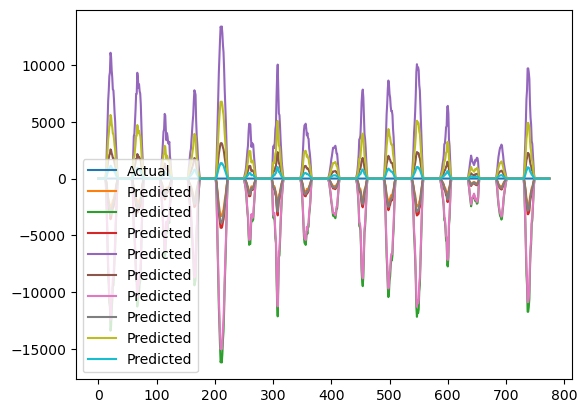

In [88]:
#compare predictions with actual values
import matplotlib.pyplot as plt

plt.plot(Y.values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()


In [99]:
#pinball loss on test data
def pinball_loss(y_true, y_pred, quantile):
    delta = y_true - y_pred
    return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
losses = [pinball_loss(Y.values*2779.046078417549, predictions[:, i]*2779.046078417549, quantiles[i]) for i in range(9)]
losses

[105435.92398796474,
 1040860.8619051626,
 417400.55753857613,
 2581780.0406818767,
 498738.58598533523,
 2896138.4859482385,
 874072.4267415961,
 435249.80796534446,
 43706.53011176695]

In [95]:
predictions[:, 0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [92]:
Y.values*2779.046078417549

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.58430772e-04, 1.01414036e+01, 3.28303787e+01, 6.38246791e+01,
       9.77182720e+01, 1.38947339e+02, 1.96336890e+02, 2.55314120e+02,
       2.68456119e+02, 3.51399284e+02, 3.42402564e+02, 2.63660189e+02,
       2.08048146e+02, 2.46885156e+02, 2.26381162e+02, 1.92218770e+02,
       1.88786343e+02, 1.99719257e+02, 1.23074535e+02, 9.76238283e+01,
       4.32852438e+01, 1.37059747e+01, 4.17382693e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [49]:
for i in losses:
    print(i*2779.046078417549)

0.004726246267038594
0.012923791571944884
0.037031980552171384
0.01618043408177015
0.020695928081086935
0.02574623390933673
0.02368182568605747
0.029830108599002945
0.015665375370771673


In [47]:
#average error
error = np.mean(np.abs(predictions[:,4] - Y.values))
error

0.02106127040068325

In [ ]:
# X_scaled_light_gbm = df_resampled_merged_solar2[[ 
#     "Mean_SolarDownwardRadiation",
#     "SolarDownwardRadiation_RW_Mean_1hour",
#     "SolarDownwardRadiation_RW_Mean_30min",
#     "SolarDownwardRadiation_dwd_Mean_Lag_30min",
#     "SolarDownwardRadiation_dwd_Mean_Lag_1h",
#     "SolarDownwardRadiation_dwd_Mean_Lag_24h",
#     "Panel_Efficiency_dwd_mean",
#     "Panel_Efficiency_dwd_std",
#     "Panel_Temperature_dwd_mean",
#     "Panel_Temperature_dwd_std",
#     "Std_Temperature",
#     "Mean_Temperature",
#     "cos_hour",
#     "cos_day_of_year",
#     "capacity_mwp_lag_48h",
#     "solar_mw_lag_48h",
#     "generation_mw"
#     ]]
# X_scaled_light_gbm.dropna(inplace=True)
# Y_light_gbm = X_scaled_light_gbm.generation_mw
# X_scaled_light_gbm.drop(columns=["generation_mw"], inplace=True)

In [77]:
X_scaled_light_gbm = df_resampled_merged_solar2[[ 
            "Mean_SolarDownwardRadiation",
            "SolarDownwardRadiation_RW_Mean_1hour",
            "SolarDownwardRadiation_RW_Mean_30min",
            "SolarDownwardRadiation_dwd_Mean_Lag_30min",
            "SolarDownwardRadiation_dwd_Mean_Lag_1h",
            "SolarDownwardRadiation_dwd_Mean_Lag_24h",
            "Panel_Efficiency_dwd_mean",
            "Panel_Efficiency_dwd_std",
            "Panel_Temperature_dwd_mean",
            "Panel_Temperature_dwd_std",
            "Std_Temperature",
            "Mean_Temperature",
            "cos_hour",
            "cos_day_of_year",
            "solar_mw_lag_48h",
            "capacity_mwp_lag_48h",
            "Target_Capacity_MWP%_lag_48h",
            "generation_mw"
            ]]
X_scaled_light_gbm.dropna(inplace=True)
Y_light_gbm = X_scaled_light_gbm.generation_mw
X_scaled_light_gbm.drop(columns=["generation_mw"], inplace=True)

C:\Users\paulh\AppData\Local\Temp\ipykernel_29320\1823447650.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\paulh\AppData\Local\Temp\ipykernel_29320\1823447650.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
X_scaled_light_gbm.solar_mw_lag_48h.describe()

count    775.000000
mean      95.709253
std      166.898008
min        0.000000
25%        0.000000
50%        0.000000
75%      135.875608
max      826.541075
Name: solar_mw_lag_48h, dtype: float64

In [78]:
def modified_pinball_loss(y_true, y_pred, quantile):
    delta = y_true - y_pred
    return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))

In [90]:
path = "D:/Users/paulh/Desktop/Domäneprojekt2/Energy_production_price_prediction/Generation_forecast/Solar_forecast/models/lgbr_model/models/i5_models/lgbr_q"
quantiles = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in quantiles:
    model_light = pickle.load(open(path + str(i) + ".pkl", 'rb'))
    predictions = model_light.predict(X_scaled_light_gbm)
    loss = modified_pinball_loss(Y.values*2779.046078417549, predictions*2779.046078417549, i/10)
    print(f"Quantile {i/10}: {loss}")

Quantile 0.1: 4.8404922445095195
Quantile 0.2: 6.892594185861965
Quantile 0.3: 8.8307592589559
Quantile 0.4: 9.067336730159138
Quantile 0.5: 9.476415274739017
Quantile 0.6: 9.868614651992145
Quantile 0.7: 9.71874572875102
Quantile 0.8: 9.435637102459237
Quantile 0.9: 4.928682402492563


In [59]:
import plotly.express as px

# Initialize dictionary to store results
quantiles = [i for i in range(1, 10)]  # Define quantiles (adjust as needed)
results = {"Actual": Y.values}  # Start with actual values

# Iterate through each quantile, load model, predict, and store predictions
for i in quantiles:
    quantile = i / 10
    model_light = pickle.load(open(path + str(i) + ".pkl", 'rb'))
    predictions = model_light.predict(X_scaled_light_gbm)
    
    # Store predictions for each quantile
    results[f"Quantile_{quantile}"] = predictions

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Melt the DataFrame for plotting with Plotly Express
results_melted = results_df.melt(var_name="Series", value_name="Values")

# Plot the predictions and actual values
fig = px.line(results_melted, x=results_melted.index, y="Values", color="Series",
              title="Quantile Predictions vs Actual Values",
              labels={"index": "Sample Index", "Values": "Values"})
fig.show()

In [50]:
#ensemble light gbm MLP
quantiles = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for i in quantiles:
    model_light = pickle.load(open(path + str(i) + ".pkl", 'rb'))
    predictions_light = model_light.predict(X_scaled_light_gbm)
    predictions_mlp = predictions[:, i - 1]
    predictions_together = (predictions_light + predictions_mlp) / 2
    loss = modified_pinball_loss(Y.values, predictions_together, i/10)
    print(f"Quantile {i/10}: {loss}")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [124]:
predictions.shape

(248, 9)

In [123]:
predictions[:,0]

array([-7.51077244e-03, -7.58840982e-03, -7.84721412e-03, -7.89280795e-03,
       -8.35885480e-03, -8.39578733e-03, -8.73092003e-03, -8.73678830e-03,
       -8.73866584e-03, -8.73721577e-03, -8.94524250e-03, -9.09274817e-03,
        9.38260835e-03,  1.20034897e+00,  1.34834194e+01,  2.36454048e+01,
        3.61474838e+01,  4.46787109e+01,  5.58199005e+01,  6.35176468e+01,
        7.39101334e+01,  8.69730148e+01,  1.14276726e+02,  1.20634590e+02,
        1.14855721e+02,  1.11552460e+02,  1.00484428e+02,  9.33061905e+01,
        8.55384216e+01,  7.84270706e+01,  6.59256973e+01,  5.33916702e+01,
        3.13498173e+01,  2.24399872e+01,  6.81227541e+00,  4.41856098e+00,
        2.19585761e-01,  1.10206895e-01, -8.71351641e-03, -8.74364376e-03,
       -8.74361396e-03, -8.54542851e-03, -8.56065657e-03, -8.27816129e-03,
       -8.22702143e-03, -7.97285885e-03, -7.99657777e-03, -8.17807298e-03,
       -8.18353612e-03, -8.53335392e-03, -8.54000263e-03, -8.72171763e-03,
       -8.72085243e-03, -